# Modèles PyTorch - Classification et Régression

Ce notebook implémente deux modèles simples avec PyTorch:
1. **Classification**: Prédire si un étudiant va compléter le cours (Completed: 0 ou 1)
2. **Régression**: Prédire Quiz_Score_Avg, Project_Grade, Satisfaction_Rating, Time_Spent_Hours

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Vérifier si GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cpu


## 1. Chargement des données

In [ ]:
# Classification
X_class = pd.read_csv('../data/processed/X_classification.csv')
y_class = pd.read_csv('../data/processed/y_classification.csv')

# Régression
X_reg = pd.read_csv('../data/processed/X_regression.csv')
y_reg = pd.read_csv('../data/processed/y_regression.csv')

print("CLASSIFICATION:")
print(f"  X_class: {X_class.shape}")
print(f"  y_class: {y_class.shape}")

print("\nREGRESSION:")
print(f"  X_reg: {X_reg.shape}")
print(f"  y_reg: {y_reg.shape}")

CLASSIFICATION:
  X_class: (56172, 40)
  y_class: (56172, 1)

REGRESSION:
  X_reg: (56172, 37)
  y_reg: (56172, 4)


---
# PARTIE 1: MODELE DE CLASSIFICATION
---

**Objectif**: Prédire si un étudiant va compléter le cours (0 ou 1)

In [ ]:
# Conversion en numpy arrays
X_class_np = X_class.values
y_class_np = y_class.values.ravel()  # ravel() pour avoir un vecteur 1D

# Split train/test (80% train, 20% test)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_np, y_class_np, test_size=0.2, random_state=42
)

# Normalisation des features
scaler_class = StandardScaler()
X_train_class = scaler_class.fit_transform(X_train_class)
X_test_class = scaler_class.transform(X_test_class)

# Conversion en tenseurs PyTorch
X_train_class_tensor = torch.FloatTensor(X_train_class).to(device)
X_test_class_tensor = torch.FloatTensor(X_test_class).to(device)
y_train_class_tensor = torch.FloatTensor(y_train_class).to(device)
y_test_class_tensor = torch.FloatTensor(y_test_class).to(device)

print(f"Train: {X_train_class_tensor.shape}, Test: {X_test_class_tensor.shape}")

Train: torch.Size([44937, 40]), Test: torch.Size([11235, 40])


In [ ]:
# Réseau de neurones simple avec 2 couches cachées

# Nombre de features en entrée
input_size_class = X_train_class_tensor.shape[1]

# Définition du modèle
class ClassificationModel(nn.Module):
    def __init__(self, input_size):
        super(ClassificationModel, self).__init__()
        # Couche 1: input -> 64 neurones
        self.layer1 = nn.Linear(input_size, 64)
        # Couche 2: 64 -> 32 neurones
        self.layer2 = nn.Linear(64, 32)
        # Couche de sortie: 32 -> 1 (probabilité)
        self.output = nn.Linear(32, 1)
        # Fonction d'activation ReLU
        self.relu = nn.ReLU()
        # Sigmoid pour la sortie (probabilité entre 0 et 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

# Création du modèle
model_class = ClassificationModel(input_size_class).to(device)
print(model_class)

ClassificationModel(
  (layer1): Linear(in_features=40, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [ ]:
# ENTRAINEMENT - CLASSIFICATION

# Fonction de perte: Binary Cross Entropy
criterion_class = nn.BCELoss()

# Optimiseur: Adam avec learning rate = 0.001
optimizer_class = torch.optim.Adam(model_class.parameters(), lr=0.001)

# Nombre d'epochs
epochs = 1000

# Listes pour stocker les pertes
train_losses_class = []

# Boucle d'entraînement
for epoch in range(epochs):
    # Mode entraînement
    model_class.train()
    
    # Forward pass
    y_pred = model_class(X_train_class_tensor)
    
    # Calcul de la perte
    loss = criterion_class(y_pred.squeeze(), y_train_class_tensor)
    
    # Backward pass
    optimizer_class.zero_grad()  # Réinitialiser les gradients
    loss.backward()              # Calculer les gradients
    optimizer_class.step()       # Mettre à jour les poids
    
    # Stocker la perte
    train_losses_class.append(loss.item())
    
    # Afficher la progression tous les 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("\nEntraînement terminé!")

Epoch [10/1000], Loss: 0.6506
Epoch [20/1000], Loss: 0.6489
Epoch [30/1000], Loss: 0.6471
Epoch [40/1000], Loss: 0.6452
Epoch [50/1000], Loss: 0.6431
Epoch [60/1000], Loss: 0.6409
Epoch [70/1000], Loss: 0.6385
Epoch [80/1000], Loss: 0.6360
Epoch [90/1000], Loss: 0.6334
Epoch [100/1000], Loss: 0.6308
Epoch [110/1000], Loss: 0.6281
Epoch [120/1000], Loss: 0.6254
Epoch [130/1000], Loss: 0.6227
Epoch [140/1000], Loss: 0.6202
Epoch [150/1000], Loss: 0.6178
Epoch [160/1000], Loss: 0.6157
Epoch [170/1000], Loss: 0.6137
Epoch [180/1000], Loss: 0.6119
Epoch [190/1000], Loss: 0.6101
Epoch [200/1000], Loss: 0.6085
Epoch [210/1000], Loss: 0.6070
Epoch [220/1000], Loss: 0.6056
Epoch [230/1000], Loss: 0.6043
Epoch [240/1000], Loss: 0.6031
Epoch [250/1000], Loss: 0.6020
Epoch [260/1000], Loss: 0.6011
Epoch [270/1000], Loss: 0.6001
Epoch [280/1000], Loss: 0.5993
Epoch [290/1000], Loss: 0.5985
Epoch [300/1000], Loss: 0.5977
Epoch [310/1000], Loss: 0.5970
Epoch [320/1000], Loss: 0.5963
Epoch [330/1000],

In [ ]:
# EVALUATION - CLASSIFICATION

# Mode évaluation
model_class.eval()

# Prédictions sur le test set
with torch.no_grad():  # Désactiver le calcul des gradients
    y_pred_test = model_class(X_test_class_tensor)
    # Convertir les probabilités en classes (seuil = 0.5)
    y_pred_classes = (y_pred_test.squeeze() > 0.5).float()

# Calcul de l'accuracy
y_pred_classes_np = y_pred_classes.cpu().numpy()
y_test_class_np = y_test_class_tensor.cpu().numpy()

accuracy = accuracy_score(y_test_class_np, y_pred_classes_np)
print(f"Accuracy sur le test set: {accuracy:.4f} ({accuracy*100:.2f}%)")

Accuracy sur le test set: 0.5613 (56.13%)


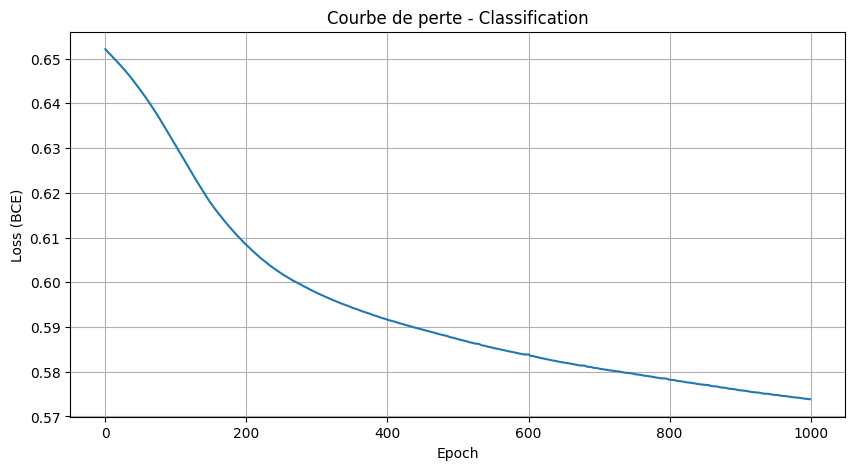

In [ ]:
# VISUALISATION - CLASSIFICATION
plt.figure(figsize=(10, 5))
plt.plot(train_losses_class)
plt.title('Courbe de perte - Classification')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.grid(True)
plt.show()

---
# PARTIE 2: MODELE DE REGRESSION
---

**Objectif**: Prédire 4 variables continues:
- Quiz_Score_Avg
- Project_Grade  
- Satisfaction_Rating
- Time_Spent_Hours

In [ ]:
# PREPARATION DES DONNEES - REGRESSION

# Conversion en numpy arrays
X_reg_np = X_reg.values
y_reg_np = y_reg.values

# Split train/test (80% train, 20% test)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_np, y_reg_np, test_size=0.2, random_state=42
)

# Normalisation des features X
scaler_X_reg = StandardScaler()
X_train_reg = scaler_X_reg.fit_transform(X_train_reg)
X_test_reg = scaler_X_reg.transform(X_test_reg)

# Normalisation des cibles y (important pour la régression multi-output)
scaler_y_reg = StandardScaler()
y_train_reg = scaler_y_reg.fit_transform(y_train_reg)
y_test_reg = scaler_y_reg.transform(y_test_reg)

# Conversion en tenseurs PyTorch
X_train_reg_tensor = torch.FloatTensor(X_train_reg).to(device)
X_test_reg_tensor = torch.FloatTensor(X_test_reg).to(device)
y_train_reg_tensor = torch.FloatTensor(y_train_reg).to(device)
y_test_reg_tensor = torch.FloatTensor(y_test_reg).to(device)

print(f"Train: {X_train_reg_tensor.shape}, Test: {X_test_reg_tensor.shape}")
print(f"Cibles: {y_train_reg_tensor.shape[1]} variables à prédire")

Train: torch.Size([44937, 37]), Test: torch.Size([11235, 37])
Cibles: 4 variables à prédire


In [ ]:
# MODELE DE REGRESSION
# Réseau de neurones simple avec 2 couches cachées

# Nombre de features en entrée et nombre de sorties
input_size_reg = X_train_reg_tensor.shape[1]
output_size_reg = y_train_reg_tensor.shape[1]  # 4 variables à prédire

# Définition du modèle
class RegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionModel, self).__init__()
        # Couche 1: input -> 64 neurones
        self.layer1 = nn.Linear(input_size, 64)
        # Couche 2: 64 -> 32 neurones
        self.layer2 = nn.Linear(64, 32)
        # Couche de sortie: 32 -> 4 (une par variable cible)
        self.output = nn.Linear(32, output_size)
        # Fonction d'activation ReLU
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)  # Pas d'activation pour la régression
        return x

# Création du modèle
model_reg = RegressionModel(input_size_reg, output_size_reg).to(device)
print(model_reg)

RegressionModel(
  (layer1): Linear(in_features=37, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
)


In [ ]:
# ENTRAINEMENT - REGRESSION

# Fonction de perte: Mean Squared Error
criterion_reg = nn.MSELoss()

# Optimiseur: Adam avec learning rate = 0.001
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=0.001)

# Nombre d'epochs
epochs = 1000

# Listes pour stocker les pertes
train_losses_reg = []

# Boucle d'entraînement
for epoch in range(epochs):
    # Mode entraînement
    model_reg.train()
    
    # Forward pass
    y_pred = model_reg(X_train_reg_tensor)
    
    # Calcul de la perte
    loss = criterion_reg(y_pred, y_train_reg_tensor)
    
    # Backward pass
    optimizer_reg.zero_grad()  # Réinitialiser les gradients
    loss.backward()            # Calculer les gradients
    optimizer_reg.step()       # Mettre à jour les poids
    
    # Stocker la perte
    train_losses_reg.append(loss.item())
    
    # Afficher la progression tous les 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("\nEntraînement terminé!")

Epoch [10/1000], Loss: 0.9372
Epoch [20/1000], Loss: 0.9310
Epoch [30/1000], Loss: 0.9230
Epoch [40/1000], Loss: 0.9124
Epoch [50/1000], Loss: 0.8982
Epoch [60/1000], Loss: 0.8800
Epoch [70/1000], Loss: 0.8577
Epoch [80/1000], Loss: 0.8319
Epoch [90/1000], Loss: 0.8042
Epoch [100/1000], Loss: 0.7782
Epoch [110/1000], Loss: 0.7559
Epoch [120/1000], Loss: 0.7407
Epoch [130/1000], Loss: 0.7320
Epoch [140/1000], Loss: 0.7272
Epoch [150/1000], Loss: 0.7242
Epoch [160/1000], Loss: 0.7220
Epoch [170/1000], Loss: 0.7202
Epoch [180/1000], Loss: 0.7187
Epoch [190/1000], Loss: 0.7176
Epoch [200/1000], Loss: 0.7166
Epoch [210/1000], Loss: 0.7157
Epoch [220/1000], Loss: 0.7150
Epoch [230/1000], Loss: 0.7143
Epoch [240/1000], Loss: 0.7138
Epoch [250/1000], Loss: 0.7133
Epoch [260/1000], Loss: 0.7128
Epoch [270/1000], Loss: 0.7123
Epoch [280/1000], Loss: 0.7119
Epoch [290/1000], Loss: 0.7115
Epoch [300/1000], Loss: 0.7111
Epoch [310/1000], Loss: 0.7108
Epoch [320/1000], Loss: 0.7105
Epoch [330/1000],

In [ ]:
# EVALUATION - REGRESSION

# Mode évaluation
model_reg.eval()

# Prédictions sur le test set
with torch.no_grad():
    y_pred_test_reg = model_reg(X_test_reg_tensor)

# Conversion en numpy pour les métriques
y_pred_reg_np = y_pred_test_reg.cpu().numpy()
y_test_reg_np = y_test_reg_tensor.cpu().numpy()

# Inverser la normalisation pour avoir les vraies valeurs
y_pred_reg_original = scaler_y_reg.inverse_transform(y_pred_reg_np)
y_test_reg_original = scaler_y_reg.inverse_transform(y_test_reg_np)

# Calcul des métriques pour chaque variable cible
target_names = ['Quiz_Score_Avg', 'Project_Grade', 'Satisfaction_Rating', 'Time_Spent_Hours']

print("Métriques sur le test set:")
print("="*60)
for i, name in enumerate(target_names):
    mse = mean_squared_error(y_test_reg_original[:, i], y_pred_reg_original[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg_original[:, i], y_pred_reg_original[:, i])
    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print()

Métriques sur le test set:
Quiz_Score_Avg:
  RMSE: 12.3702
  R²: 0.0370

Project_Grade:
  RMSE: 1.4006
  R²: 0.9916

Satisfaction_Rating:
  RMSE: 0.7089
  R²: -0.0026

Time_Spent_Hours:
  RMSE: 3.7177
  R²: 0.0349



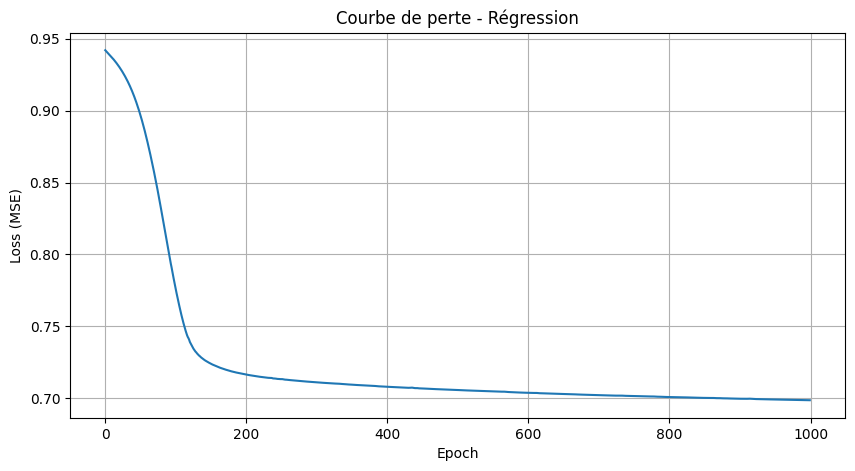

In [ ]:
# VISUALISATION - REGRESSION

# Courbe de perte
plt.figure(figsize=(10, 5))
plt.plot(train_losses_reg)
plt.title('Courbe de perte - Régression')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

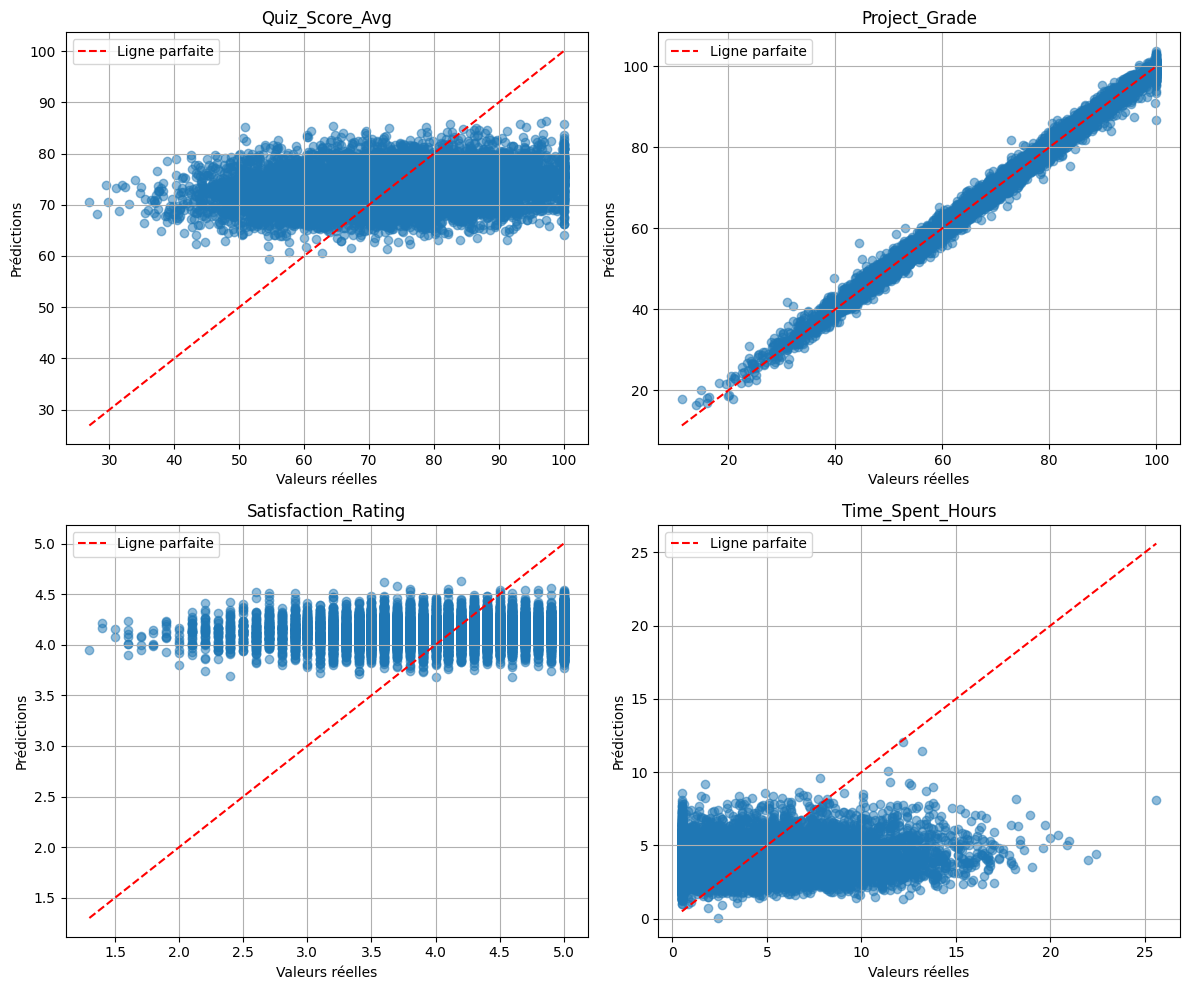

In [ ]:
# VISUALISATION - PREDICTIONS vs VALEURS REELLES

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (ax, name) in enumerate(zip(axes, target_names)):
    ax.scatter(y_test_reg_original[:, i], y_pred_reg_original[:, i], alpha=0.5)
    ax.plot([y_test_reg_original[:, i].min(), y_test_reg_original[:, i].max()],
            [y_test_reg_original[:, i].min(), y_test_reg_original[:, i].max()],
            'r--', label='Ligne parfaite')
    ax.set_xlabel('Valeurs réelles')
    ax.set_ylabel('Prédictions')
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## Résumé

### Architecture des modèles

Les deux modèles utilisent une architecture simple:
- **Couche 1**: Entrée → 64 neurones (ReLU)
- **Couche 2**: 64 → 32 neurones (ReLU)
- **Couche de sortie**: 
  - Classification: 32 → 1 (Sigmoid)
  - Régression: 32 → 4 (pas d'activation)

### Hyperparamètres
- Optimiseur: Adam
- Learning rate: 0.001
- Epochs: 100
- Fonction de perte:
  - Classification: Binary Cross Entropy (BCELoss)
  - Régression: Mean Squared Error (MSELoss)